# Style Transfer with TensorFlow

#### May 28th, 2017
### Satchel Grant

## Overview
This notebook serves as a walk through of a TensorFlow implementation of style transfer.

Style transfer is the process of blending the style of a image with the form of another image. For example the left and right images are style transferred to generate the middle image.

![image1](./imgs/satch_gogh_combined.jpg)
![image2](./imgs/abbas_starry_blend.jpg)
![image3](./imgs/benj_picasso_combined.jpg)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
import scipy.ndimage as scimg
import utils.vgg16_avg as vgg
from PIL import Image
import time

In [2]:
def show(img):
    plt.imshow(img)
    plt.show()

### Loading the Image

In [3]:
img_path = './imgs/satch_gogh.jpg'

In [4]:
img_size = (800,600)
img = Image.open(img_path)
img = img.resize(img_size)
left, top, right, bottom = (img_size[0]//8,6*img_size[1]//30,7*img_size[0]//8,9*img_size[1]//12)
print(left,top,right,bottom)
img = img.crop((left,top,right,bottom))
img = img.resize(img_size)
img = np.asarray(img).astype(np.float32)
img = img / 255 # scaled for vgg16
print(img.shape)

100 120 700 450
(600, 800, 3)


Here we crop the image so that the high level features will match up better with the high level features of the Van Gogh self portrait. Similar placements of eyes, noses, mouths, etc. helps the styling look more natural.

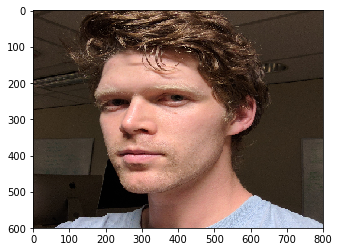

In [5]:
show(img)

### Loading the Style

In [6]:
style = Image.open('./imgs/van_gogh.jpg')
style = style.resize(img_size)
left,top,right,bottom = (img_size[0]//4,0,img_size[0],img_size[1])
style = style.crop((left,top,right,bottom))
style = style.resize(img_size)
style = np.asarray(style) / 255
print(style.shape)

(600, 800, 3)


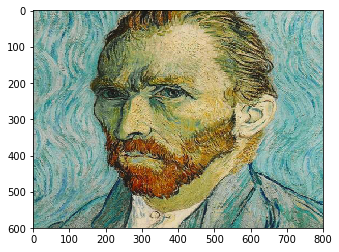

In [7]:
show(style)

### Initial Generation Image

`gen_img` (defined in the next cell) is the initial pixel array that will be optimized to blend the original image and style.

The starting form of the `gen_img` can have a significant impact on the resulting image. In this notebook, we use a gaussian blur on the original image. This ensures that the final, optimized image will have a similar form to the original image.

In [16]:
gen_img = img.copy()
gen_img = scimg.gaussian_filter(gen_img, 10)

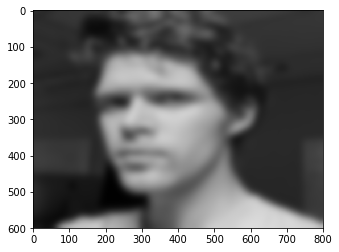

(600, 800, 3)


In [17]:
show(gen_img)
print(gen_img.shape)

In [13]:
vmodel = vgg.Vgg16('../../vgg16.npy')

npy file loaded


## Image Generation

This section walks through generating the image without styling.

The `eval_conv` is the specified convolutional layer from the vgg network that we want our outputs to exit at. The later in the network we go, the more abstract and high level the features will be. Usually layers past 4.1 are too abstract to maintain semblence of the original image.

In [18]:
eval_conv = 4.2

In [19]:
tfimg = tf.placeholder(tf.float32, [None]+[s for s in img.shape], name='tfimg')
trgt = vmodel.run_convs(tfimg, eval_conv)

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    target_img = sess.run(trgt, feed_dict={tfimg:[img]})

In [21]:
trgt_const = tf.convert_to_tensor(target_img, dtype=tf.float32)
img_output = vmodel.run_convs(tfimg, eval_conv)

In [42]:
img_loss = tf.reduce_mean(tf.squared_difference(img_output, trgt_const))
img_grads = tf.gradients(img_loss, tfimg)

`img_gradloss` is a function that will be used with scipy's `fmin_l_bfgs_b` optimizer. The noteworthy part of our loss function is that we are optimizing the pixels of the `gen_img` rather than the weights of the network.

In [47]:
def img_gradloss(gen_img, sess):
    loss, grads = sess.run([img_loss, img_grads], feed_dict={tfimg:gen_img})
    return loss, np.asarray(grads)

The `fmin_l_bfgs_b` optimizer needs a function to calculate the loss and gradients for each pixel in the `gen_img`. In order for us do this efficiently with one function we can create a class to hold the function and keep track of the loss and gradients. The Evaluator class does exactly this.

In [48]:
class Evaluator(object):
    def __init__(self, fxn, shape, sess):
        self.fxn = fxn
        self.shape = shape
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
    
    def loss(self, x):
        loss_, self.grad_vals = self.fxn(x.reshape(self.shape), self.sess)
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grad_vals.flatten().astype(np.float64)

Finally, we can solve for the optimal pixel values given our loss function using `fmin_l_bfgs_b`.

In [49]:
def solve_image(eval_obj, n_iters, x):
    for i in range(n_iters):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, 0,1)
        print("Step",i,'- Loss:', min_val)
    eval_obj.sess.close()
    return x

At this stage, our loss function is only calculating the difference of our generated image's convolved pixels from the initial image's convolved pixels. No style is involved yet.

In [50]:
sess = tf.Session()
evaluator = Evaluator(img_gradloss, [1]+[s for s in gen_img.shape], sess)

In [51]:
matched_img = solve_image(evaluator, 5, np.reshape(gen_img, [1]+[s for s in gen_img.shape]))
matched_img = matched_img.reshape(gen_img.shape)

Step 0 - Loss: 536.059875488
Step 1 - Loss: 258.472198486
Step 2 - Loss: 170.346939087
Step 3 - Loss: 130.759292603
Step 4 - Loss: 108.21925354


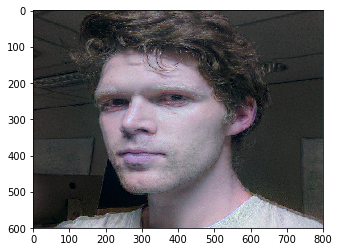

In [52]:
show((matched_img*255).astype(np.uint8))

I look like I'm dead.. Creepy!

### Style Generation

`styleconvs` is a list of activations from various convolutional layers in the vgg network. We use multiple activation layers because it captures different levels of the style of the original style image. The earlier layers translate foundational features of the style (brush strokes, simple lines, etc.) while the later layers capture the more complex features in the style image.

In [ ]:
conv_ = .3 # specific conv layer designation (see utils/vgg16_avg.py run_convs())
styleweights = [1,2,3,0] # weights for loss function at each conv output

In [24]:
tfstyle = tf.placeholder(tf.float32, [1]+[s for s in style.shape], name="tfstyle")
styleconvs = [vmodel.run_convs(tfstyle, i+conv_) for i in range(1,len(styleweights)+1)]

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    target_styles = sess.run(styleconvs, feed_dict={tfstyle:[style]})

One of the most interesting parts of this project is the use of a gram matrix to obtain a 'finger print' of the style.

A gram matrix is obtained by a matrix multiplication of a matrix with its transpose. This gives a qualitative statistic on how much each row has in common with the others.

We use the gram matrix of each activation layer as our target in the loss function. Why exactly the gram matrix works as a target is still somewhat unknown.

It is also worth noting that two potential gram matrices are obtainable for a given matrix. We have a component in the loss function for each.

In [26]:
def gram_matrix(activs):
    reshape1 = tf.transpose(activs,perm=[0,3,1,2])
    reshape2 = tf.transpose(activs,perm=[0,3,2,1])
    output = tf.matmul(reshape1,reshape2)
    return tf.reshape(output,[-1])/(224*224)

def gram_matrix_rev(activs):
    reshape1 = tf.transpose(activs,perm=[0,3,1,2])
    reshape2 = tf.transpose(activs,perm=[0,3,2,1])
    output = tf.matmul(reshape2,reshape1)
    return tf.reshape(output,[-1])/(224*224)

def style_loss(l1, l2):
    return tf.reduce_mean(tf.squared_difference(gram_matrix(l1), gram_matrix(l2)))

def style_loss_rev(l1,l2):
    return tf.reduce_mean(tf.squared_difference(gram_matrix_rev(l1), gram_matrix_rev(l2)))

In [28]:
stylelayers = [tf.convert_to_tensor(s, dtype=tf.float32) for s in target_styles]
imglayers = [vmodel.run_convs(tfimg, i+conv_) for i in range(1,len(styleweights)+1)]

In [53]:
tfstyle_ws = tf.placeholder(tf.float32, [len(styleweights)])
count = [i for i in range(len(styleweights))]
styleloss = tf.reduce_mean([tf.gather(tfstyle_ws,i)*(style_loss_rev(l1,l2)+style_loss(l1,l2)) \
                           for l1,l2,i in zip(stylelayers, imglayers, count)])
stylegrads = tf.gradients(styleloss, tfimg)

In [54]:
def style_gradloss(img, sess, ws):
    cost, grads = sess.run([styleloss, stylegrads], feed_dict={tfimg:img, tfstyle_ws:ws})
    return cost, np.asarray(grads)

The StyleEvaluator class is used for viewing the optimized images at individual convolutional layers. This can give an idea as to which convolutional layers to use and how to weight them for your goals with the image.

In [55]:
class StyleEvaluator(Evaluator):
    def __init__(self, fxn, shape, sess, ws):
        Evaluator.__init__(self, fxn, shape, sess)
        self.ws = ws
    
    def loss(self, x):
        loss_, self.grad_vals = self.fxn(x.reshape(self.shape), self.sess, self.ws)
        return loss_.astype(np.float64)

Step 0 - Loss: 4311.90234375
Step 1 - Loss: 386.083129883
Step 2 - Loss: 194.528518677
Step 3 - Loss: 118.025512695


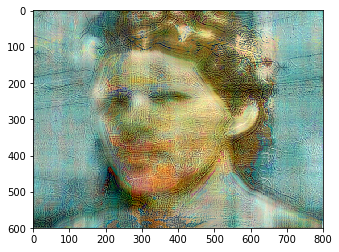

Step 0 - Loss: 733.536987305
Step 1 - Loss: 318.526428223
Step 2 - Loss: 241.557434082
Step 3 - Loss: 210.673034668


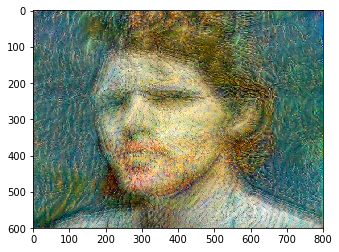

Step 0 - Loss: 715.335144043
Step 1 - Loss: 377.106872559
Step 2 - Loss: 288.973571777
Step 3 - Loss: 256.405883789


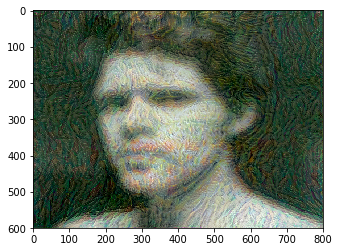

Step 0 - Loss: 0.0343980900943
Step 1 - Loss: 0.0230895765126
Step 2 - Loss: 0.0179473273456
Step 3 - Loss: 0.0175184123218


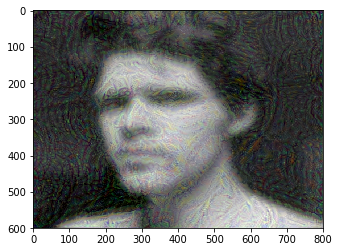

In [56]:
for i in range(len(styleweights)):
    ws = [0]*len(styleweights)
    ws[i] = 1
    sess = tf.Session()
    evaluator = StyleEvaluator(style_gradloss, [1]+[s for s in gen_img.shape], sess, ws)
    test_img = solve_image(evaluator, 4, np.reshape(gen_img, [1]+[s for s in gen_img.shape]))
    test_img = test_img.reshape(gen_img.shape)
    show((test_img*255).astype(np.uint8))

### Combined

The process just completed for both the image and style sections is essentially repeated here. The

In [29]:
img_weight = 1
style_weight = 2

In [30]:
combined_loss = img_weight*tf.reduce_mean(tf.squared_difference(img_output, trgt_const)) +\
                style_weight*tf.reduce_mean([w*(style_loss(l1,l2)+style_loss_rev(l1,l2)) for l1,l2,w in zip(stylelayers, imglayers, styleweights) if w != 0])

In [31]:
combined_grads = tf.gradients(combined_loss, tfimg)

In [32]:
def combined_gradloss(img, sess):
    cost, grads = sess.run([combined_loss, combined_grads], feed_dict={tfimg:img})
    return cost, np.asarray(grads)

In [33]:
sess = tf.Session()
evaluator = Evaluator(combined_gradloss, [1]+[s for s in gen_img.shape], sess)

In [35]:
n_iters = 10
basetime = time.time()
combined_img = solve_image(evaluator, n_iters, np.reshape(gen_img, [1]+[s for s in gen_img.shape]))
print("Execution time:", time.time()-basetime)

Step 0 - Loss: 43898.9453125
Step 1 - Loss: 19368.2324219
Step 2 - Loss: 10700.4521484
Step 3 - Loss: 7487.86181641
Step 4 - Loss: 6478.11572266
Step 5 - Loss: 5895.54248047
Step 6 - Loss: 5606.69677734
Step 7 - Loss: 5424.94238281
Step 8 - Loss: 5273.41015625
Step 9 - Loss: 5134.92773438
Execution time: 9166.459117174149


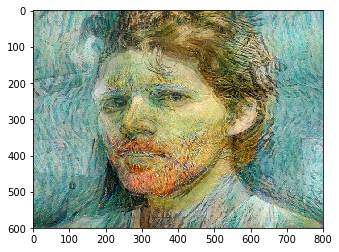

In [36]:
combined_img = combined_img.reshape(gen_img.shape)
show(combined_img)

In [39]:
save_img = Image.fromarray((combined_img*255).astype(np.uint8))
save_img.save('satch_gogh.jpg')

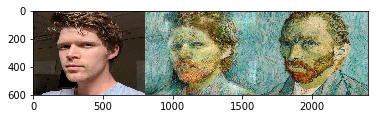

In [37]:
outimg = np.zeros([combined_img.shape[0],combined_img.shape[1]*3,3])
outimg[:,:outimg.shape[1]//3,:] = img[:,:,:]
outimg[:,outimg.shape[1]//3:2*outimg.shape[1]//3,:] = combined_img[:,:,:]
outimg[:,2*outimg.shape[1]//3:,:] = style[:,:,:]
show(outimg)

In [38]:
save_img = Image.fromarray((outimg*255).astype(np.uint8))
save_img.save('satch_gogh_combined.jpg')